# Analyze data from education systems

In [1]:
from math import prod
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib .pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

## Methods cell

In [97]:
def df_initial_analysis(df, name_df):
    """
    Initial analysis on the DataFrame.

    Args:
        df (pandas.DataFrame): DataFrame to analyze.
        name_df (str): DataFrame name.

    Returns:
        None.
        Print the initial analysis on the DataFrame. 
    """
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["Name", "Type"])
        df_resume["Records"] = list(df.count())
        
        print("\nInitial Analysis of", name_df, "dataset")
        print("--------------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty columns:        ", len(empty_cols))
        print(" + The empty column is:          ", empty_cols) if len(empty_cols) == 1 \
            else (print(" + The empty column are:          ", empty_cols) if len(empty_cols) >= 1 else None)
        print("\n- Type object and records by columns")
        print("--------------------------------------------------------------------------")
        print(df_resume.sort_values("Records", ascending=False))


def comparison_dfs(df_original, df_copy):
    """
    Create a DataFrame based on comparación between the original DataFrame and the copy DataFrame.
    Args:
        df_original (pandas.DataFrame): DataFrame original.
        df_copy (pandas.DataFrame): DataFrame copy.
    Returns:
        df_comparison (pandas.DataFrame): DataFrame comparison.
    """
    df_comparison = pd.DataFrame({
        "Moment" : ["Before", "After"],
        "Total values" : [prod(df_original.shape), prod(df_copy.shape)], 
        "Valid values" : [(prod(df_original.shape)-df_original.isna().sum().sum()), (prod(df_copy.shape)-df_copy.isna().sum().sum())],
        "Missing values" : [df_original.isna().sum().sum(), df_copy.isna().sum().sum()]
    })
    return df_comparison


def most_common_words(labels, quantity):
    """
    Split all words present in list and count how many times it
    is repeated in the list. 
    Args:
        labels (list): List of strings to split.
        quantity (int): Amount of most common words to return.
    Returns:
        counter (liste): List of words splitted with its number of ocurrences.
    """
    words = [i.split(" ", 1)[0] for i in labels]
    counter = Counter(words).most_common(quantity)
    df = pd.DataFrame(counter, columns=["Word", "Occurence number"])\
                        .sort_values(by="Occurence number", ascending=True)
    return df


def countries_by_year(df_vals):
    """
    Calculating the amount of countries by year.
    Args:
        df_vals (pandas.DataFrame): DataFrame to work.
    Returns:
        df (pandas.DataFrame): DataFrame with amount of countries by year.
    """    
    years_in_df = []
    countries_by_years = []

    for col in df_vals.columns:
        if col !="Country Code":
            df_temp = pd.DataFrame(df_vals[[col, "Country Code"]].dropna(axis="rows", how="any"))
            years_in_df.append(df_vals[col].name)
            countries_by_years.append(df_temp["Country Code"].nunique())

    df = pd.DataFrame({
            "Year" : years_in_df,
            "Countries" : countries_by_years
    })

    return df


def remove_columns_by_percentage_of_nan_values(df):
    """
    Remove columns in DataFrame based on percentage of NaN values in columns.
    Args:
        df (pandas.DataFrame): DataFrame to work.
    Returns:
        df (pandas.DataFrame): DataFrame worked.
    """
    percentage = 50 # Removing columns with more than 50% NaN values 

    for col in df.columns:
        if round(((df.shape[0] - df[col].count()) / df.shape[0]) * 100, 2) > percentage:
            print("- The column",  df[col].name, "has been removed.")
            df.drop([col], axis=1, inplace=True)

    return df

## Loading data

In [3]:
# loading Dataset and removing the empty columns (the empty columns, unnamed, etc.)
country = pd.read_csv("datasets/EdStatsCountry.csv")
serie = pd.read_csv("datasets/EdStatsSeries.csv")
country_serie = pd.read_csv("datasets/EdStatsCountry-Series.csv")
foot_note = pd.read_csv("datasets/EdStatsFootNote.csv")
data = pd.read_csv("datasets/EdStatsData.csv")

## Initial data analysis
- Knowing the entities of the datasets.<br>

    - **Country** dataset **`"EdStatsCountry.csv"`**.<br>
    Des renseignements en général sur l'économie de chaque pays du monde.
    
    - **Serie** dataset **`"EdStatsSeries.csv"`**.<br>
    Des renseignements en peu plus de détails sur les indicateurs économiques.
    
    - **Country-Serie** dataset **`"EdStatsCountry-Series.csv"`**.<br>
    La source des données sur l'information relationnelle entre **`"EdStatsCountry.csv"`** et **`"EdStatsSeries.csv"`**.

    - **Foot Note** dataset **`"EdStatsFootNote.csv"`**.<br>
    L’année d’origine des données et aussi une description sur les indicateurs.

    - **Data** dataset **`"EdStatsData.csv"`**.<br>
    Le dataset principal qui contient en détails le renseignement sur les indicateurs par an.

- Entity relationship diagram.<br>
<br>Il existe une relation **"virtuel"** entre les datasets via les colonnes **`"Country Code"`** et **`"Series Code"`** principalement.<br>
_**Il faut rester prudent avec ces relations**_.<br>
![Entity relationship diagram](img/entity_relationship.png)

### **`"Country"`** dataset

In [4]:
country.head(3)

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,...,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data,Unnamed: 31
0,ABW,Aruba,Aruba,Aruba,AW,Aruban florin,SNA data for 2000-2011 are updated from offici...,Latin America & Caribbean,High income: nonOECD,AW,...,NaN,2010,NaN,NaN,Yes,NaN,NaN,2012.0,NaN,NaN
1,AFG,Afghanistan,Afghanistan,Islamic State of Afghanistan,AF,Afghan afghani,Fiscal year end: March 20; reporting period fo...,South Asia,Low income,AF,...,General Data Dissemination System (GDDS),1979,"Multiple Indicator Cluster Survey (MICS), 2010/11","Integrated household survey (IHS), 2008",NaN,2013/14,NaN,2012.0,2000,NaN
2,AGO,Angola,Angola,People's Republic of Angola,AO,Angolan kwanza,"April 2013 database update: Based on IMF data,...",Sub-Saharan Africa,Upper middle income,AO,...,General Data Dissemination System (GDDS),1970,"Malaria Indicator Survey (MIS), 2011","Integrated household survey (IHS), 2008",NaN,2015,NaN,NaN,2005,NaN


In [5]:
# Describing the numeric columns
country.describe()

,National accounts reference year,Latest industrial data,Latest trade data,Unnamed: 31
count,32.00000,107.000000,185.000000,0.0
mean,2001.53125,2008.102804,2010.994595,NaN
std,5.24856,2.616834,2.569675,NaN
min,1987.00000,2000.000000,1995.000000,NaN
25%,1996.75000,2007.500000,2011.000000,NaN
50%,2002.00000,2009.000000,2012.000000,NaN
75%,2005.00000,2010.000000,2012.000000,NaN
max,2012.00000,2010.000000,2012.000000,NaN


In [6]:
# Resume of dataset
df_initial_analysis(country, "country")


Initial Analysis of country dataset
--------------------------------------------------------------------------
- Dataset shape:                  241 rows and 32 columns
- Total of NaN values:            2354
- Percentage of NaN:              30.52 %
- Total of full duplicates rows:  0
- Total of empty columns:         1
 + The empty column is:           ['Unnamed: 31']

- Type object and records by columns
--------------------------------------------------------------------------
                                                 Name     Type  Records
0                                        Country Code   object      241
3                                           Long Name   object      241
1                                          Short Name   object      241
2                                          Table Name   object      241
9                                           WB-2 code   object      240
4                                        2-alpha code   object      238
5         

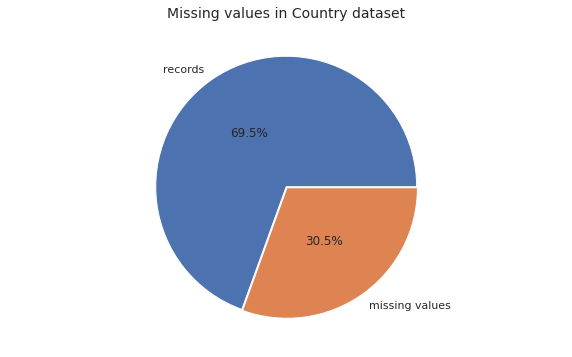

In [7]:
# Drawing missing values in Country dataset
labels = ["records", "missing values"]
vals = [prod(country.shape)-country.isna().sum().sum(), country.isna().sum().sum()]
explode = (0, 0.01)

pie, ax = plt.subplots(figsize=[10,6])
plt.axis("equal")
plt.pie(x=vals, labels=labels, explode=explode,  autopct="%.1f%%", pctdistance=0.5)
plt.title("Missing values in Country dataset", fontsize=14)
plt.show()

### **`"Serie"`** dataset

In [8]:
serie.head(3)

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
0,BAR.NOED.1519.FE.ZS,Attainment,Barro-Lee: Percentage of female population age...,Percentage of female population age 15-19 with...,Percentage of female population age 15-19 with...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BAR.NOED.1519.ZS,Attainment,Barro-Lee: Percentage of population age 15-19 ...,Percentage of population age 15-19 with no edu...,Percentage of population age 15-19 with no edu...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BAR.NOED.15UP.FE.ZS,Attainment,Barro-Lee: Percentage of female population age...,Percentage of female population age 15+ with n...,Percentage of female population age 15+ with n...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Describing the numeric columns
serie.describe()

,Unit of measure,Notes from original source,Other web links,Related indicators,License Type,Unnamed: 20
count,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Resume of dataset
df_initial_analysis(serie, "serie")


Initial Analysis of serie dataset
--------------------------------------------------------------------------
- Dataset shape:                  3665 rows and 21 columns
- Total of NaN values:            55203
- Percentage of NaN:              71.72 %
- Total of full duplicates rows:  0
- Total of empty columns:         6
 + The empty column are:           ['Unit of measure', 'Notes from original source', 'Other web links', 'Related indicators', 'License Type', 'Unnamed: 20']

- Type object and records by columns
--------------------------------------------------------------------------
                                   Name     Type  Records
0                           Series Code   object     3665
13                               Source   object     3665
2                        Indicator Name   object     3665
4                       Long definition   object     3665
1                                 Topic   object     3665
3                      Short definition   object     2156
8

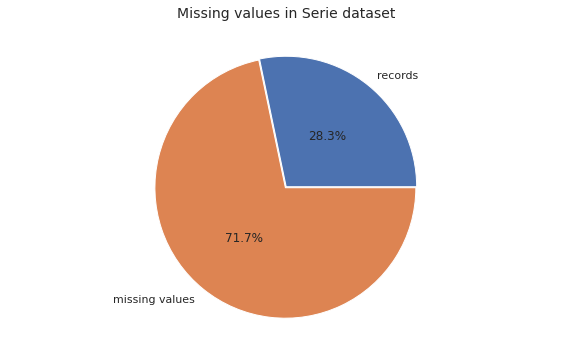

In [11]:
# Drawing missing values in Serie dataset
labels = ["records", "missing values"]
vals = [prod(serie.shape)-serie.isna().sum().sum(), serie.isna().sum().sum()]
explode = (0, 0.01)

pie, ax = plt.subplots(figsize=[10,6])
plt.axis("equal")
plt.pie(x=vals, labels=labels, explode=explode,  autopct="%.1f%%", pctdistance=0.5)
plt.title("Missing values in Serie dataset", fontsize=14)
plt.show()

### **`"Country-Serie"`** dataset

In [12]:
country_serie.head(3)

,CountryCode,SeriesCode,DESCRIPTION,Unnamed: 3
0,ABW,SP.POP.TOTL,Data sources : United Nations World Population...,NaN
1,ABW,SP.POP.GROW,Data sources: United Nations World Population ...,NaN
2,AFG,SP.POP.GROW,Data sources: United Nations World Population ...,NaN


In [13]:
# Resume of dataset
df_initial_analysis(country_serie, "country_serie")


Initial Analysis of country_serie dataset
--------------------------------------------------------------------------
- Dataset shape:                  613 rows and 4 columns
- Total of NaN values:            613
- Percentage of NaN:              25.0 %
- Total of full duplicates rows:  0
- Total of empty columns:         1
 + The empty column is:           ['Unnamed: 3']

- Type object and records by columns
--------------------------------------------------------------------------
          Name     Type  Records
0  CountryCode   object      613
1   SeriesCode   object      613
2  DESCRIPTION   object      613
3   Unnamed: 3  float64        0


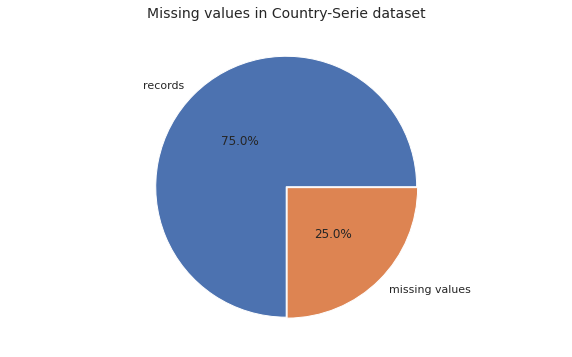

In [14]:
# Drawing missing values in Country-Serie dataset
labels = ["records", "missing values"]
vals = [prod(country_serie.shape)-country_serie.isna().sum().sum(), country_serie.isna().sum().sum()]
explode = (0, 0.01)

pie, ax = plt.subplots(figsize=[10,6])
plt.axis("equal")
plt.pie(x=vals, labels=labels, explode=explode,  autopct="%.1f%%", pctdistance=0.5)
plt.title("Missing values in Country-Serie dataset", fontsize=14)
plt.show()

### **`"Foot Note"`** dataset

In [15]:
foot_note.head(3)

,CountryCode,SeriesCode,Year,DESCRIPTION,Unnamed: 4
0,ABW,SE.PRE.ENRL.FE,YR2001,Country estimation.,NaN
1,ABW,SE.TER.TCHR.FE,YR2005,Country estimation.,NaN
2,ABW,SE.PRE.TCHR.FE,YR2000,Country estimation.,NaN


In [16]:
# Describing the numeric columns
foot_note.describe()

,Unnamed: 4
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [17]:
# Resume of dataset
df_initial_analysis(foot_note, "foot_note")


Initial Analysis of foot_note dataset
--------------------------------------------------------------------------
- Dataset shape:                  643638 rows and 5 columns
- Total of NaN values:            643638
- Percentage of NaN:              20.0 %
- Total of full duplicates rows:  0
- Total of empty columns:         1
 + The empty column is:           ['Unnamed: 4']

- Type object and records by columns
--------------------------------------------------------------------------
          Name     Type  Records
0  CountryCode   object   643638
1   SeriesCode   object   643638
2         Year   object   643638
3  DESCRIPTION   object   643638
4   Unnamed: 4  float64        0


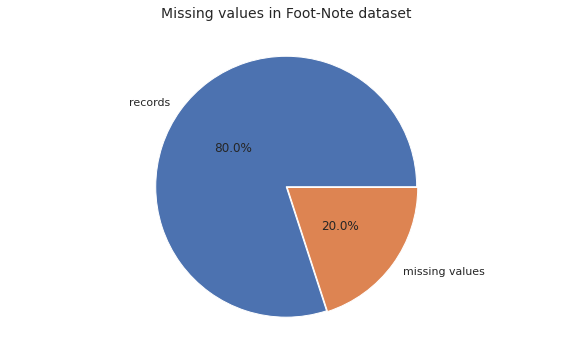

In [18]:
# Drawing missing values in Foot Note dataset
labels = ["records", "missing values"]
vals = [prod(foot_note.shape)-foot_note.isna().sum().sum(), foot_note.isna().sum().sum()]
explode = (0, 0.01)

pie, ax = plt.subplots(figsize=[10,6])
plt.axis("equal")
plt.pie(x=vals, labels=labels, explode=explode,  autopct="%.1f%%", pctdistance=0.5)
plt.title("Missing values in Foot-Note dataset", fontsize=14)
plt.show()

### **`"Data"`** dataset

In [19]:
data.head(3)

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
0,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Describing the numeric columns
data.describe()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
count,7.228800e+04,3.553700e+04,3.561900e+04,3.554500e+04,3.573000e+04,8.730600e+04,3.748300e+04,3.757400e+04,3.757600e+04,3.680900e+04,...,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,0.0
mean,1.974772e+09,4.253638e+09,4.592365e+09,5.105006e+09,5.401493e+09,2.314288e+09,5.731808e+09,6.124437e+09,6.671489e+09,7.436724e+09,...,7.224868e+02,7.271290e+02,7.283779e+02,7.266484e+02,7.228327e+02,7.176899e+02,7.113072e+02,7.034274e+02,6.940296e+02,NaN
std,1.211687e+11,1.804814e+11,1.914083e+11,2.059170e+11,2.112150e+11,1.375059e+11,2.215546e+11,2.325489e+11,2.473986e+11,2.660957e+11,...,2.215845e+04,2.287990e+04,2.352338e+04,2.408149e+04,2.455897e+04,2.496587e+04,2.530183e+04,2.556069e+04,2.574189e+04,NaN
min,-1.435564e+00,-1.594625e+00,-3.056522e+00,-4.032582e+00,-4.213563e+00,-3.658569e+00,-2.950945e+00,-3.174870e+00,-3.558749e+00,-2.973612e+00,...,-1.630000e+00,-1.440000e+00,-1.260000e+00,-1.090000e+00,-9.200000e-01,-7.800000e-01,-6.500000e-01,-5.500000e-01,-4.500000e-01,NaN
25%,8.900000e-01,8.853210e+00,9.240920e+00,9.595200e+00,9.861595e+00,1.400000e+00,9.312615e+00,9.519913e+00,1.000000e+01,1.000000e+01,...,3.000000e-02,3.000000e-02,2.000000e-02,2.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,NaN
50%,6.317724e+00,6.316240e+01,6.655139e+01,6.969595e+01,7.087760e+01,9.677420e+00,7.101590e+01,7.133326e+01,7.290512e+01,7.510173e+01,...,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.200000e-01,NaN
75%,6.251250e+01,5.655200e+04,5.863650e+04,6.202900e+04,6.383675e+04,7.854163e+01,5.682800e+04,5.739175e+04,5.940425e+04,6.411500e+04,...,7.505000e+00,7.500000e+00,7.300000e+00,7.100000e+00,6.722500e+00,6.080000e+00,5.462500e+00,4.680000e+00,4.032500e+00,NaN
max,1.903929e+13,1.986457e+13,2.100916e+13,2.238367e+13,2.282991e+13,2.300634e+13,2.424128e+13,2.521383e+13,2.622101e+13,2.730873e+13,...,2.951569e+06,3.070879e+06,3.169711e+06,3.246239e+06,3.301586e+06,3.337871e+06,3.354746e+06,3.351887e+06,3.330484e+06,NaN


In [21]:
# Resume of dataset
df_initial_analysis(data, "data")


Initial Analysis of data dataset
--------------------------------------------------------------------------
- Dataset shape:                  886930 rows and 70 columns
- Total of NaN values:            53455179
- Percentage of NaN:              86.1 %
- Total of full duplicates rows:  0
- Total of empty columns:         1
 + The empty column is:           ['Unnamed: 69']

- Type object and records by columns
--------------------------------------------------------------------------
              Name     Type  Records
0     Country Name   object   886930
2   Indicator Name   object   886930
3   Indicator Code   object   886930
1     Country Code   object   886930
44            2010  float64   242442
..             ...      ...      ...
7             1973  float64    35545
5             1971  float64    35537
50            2016  float64    16460
51            2017  float64      143
69     Unnamed: 69  float64        0

[70 rows x 3 columns]


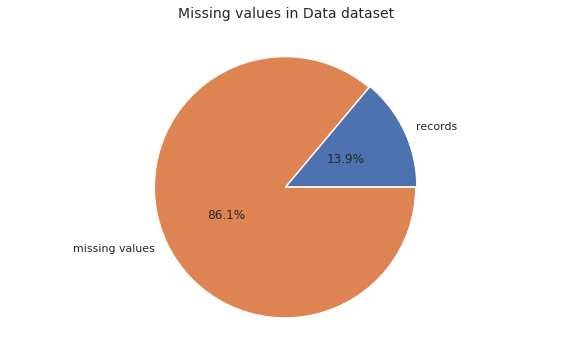

In [22]:
# Drawing missing values in Data dataset
labels = ["records", "missing values"]
vals = [prod(data.shape)-data.isna().sum().sum(), data.isna().sum().sum()]
explode = (0, 0.01)

pie, ax = plt.subplots(figsize=[10,6])
plt.axis("equal")
plt.pie(x=vals, labels=labels, explode=explode,  autopct="%.1f%%", pctdistance=0.5)
plt.title("Missing values in Data dataset", fontsize=14)
plt.show()

## Data cleanup
- Creating copies from all datasets.
- Deleting empty columns and empty rows.
- Filtring **all datasets** based on list of **`"countries"`** as given in **`"ISO 3166-1"`** .<br> 
    - **`"EdStatsCountry"`** is going to be the pivot to filter the others datasets.<br>
        - To **`"EdStatsSeries"`** the pivots are going to be **`"EdStatsCountry"`** and **`"EdStatsData"`**.<br>
    - List of **`"countries"`** as given in **`"ISO 3166-1"`** and the corresponding **`"ISO 3166-1-alpha-2"`** code elements.<br>https://datahub.io/core/country-list#resource-data 

### Loading data and removing empty columns and empty rows

In [23]:
country_copy = country.dropna(axis="columns", how="all").dropna(axis="rows", how="all")
serie_copy = serie.dropna(axis="columns", how="all").dropna(axis="rows", how="all")
country_serie_copy = country_serie.dropna(axis="columns", how="all").dropna(axis="rows", how="all")
foot_note_copy = foot_note.dropna(axis="columns", how="all").dropna(axis="rows", how="all")
data_copy = data.dropna(axis="columns", how="all").dropna(axis="rows", how="all")

### Comparing datasets before and after removing empty columns/rows

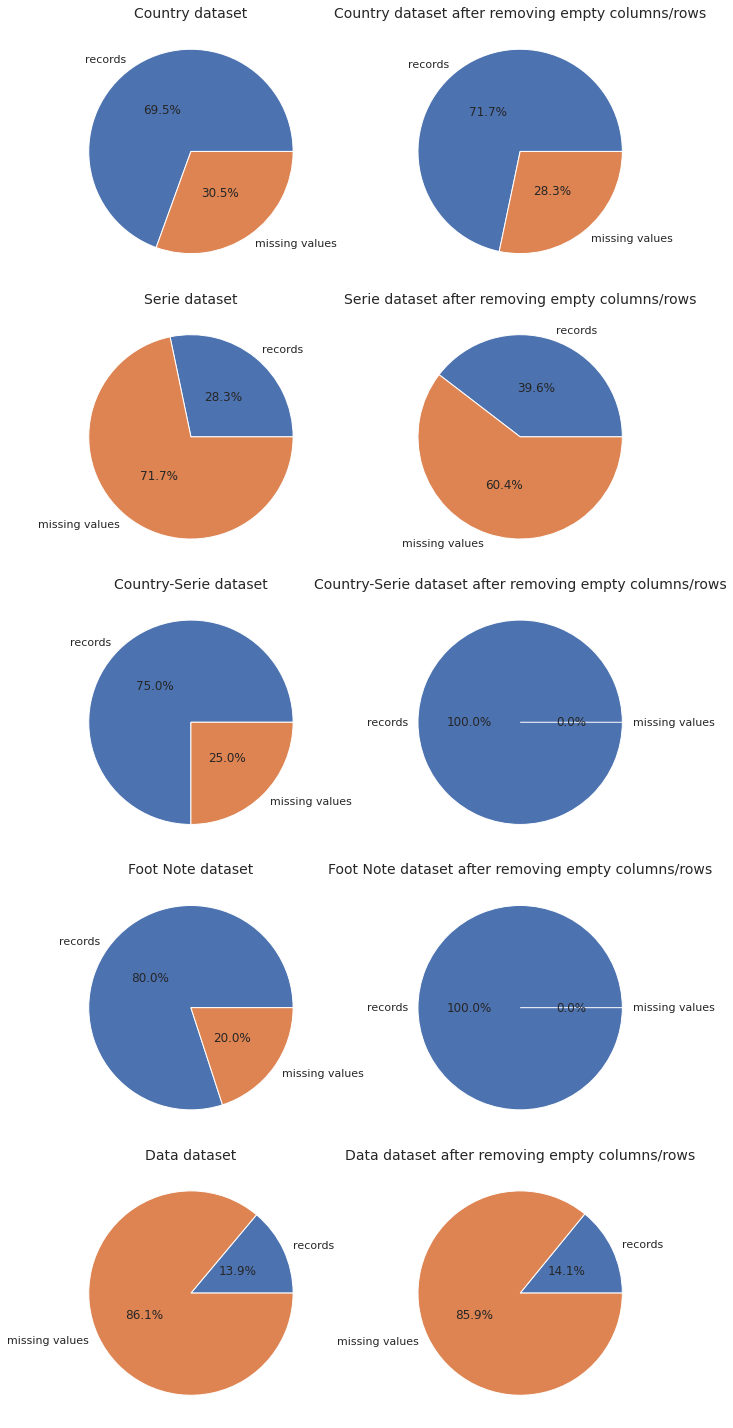

In [24]:
# Comparing missing values in all datasets before and after removing empty columns/rows
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(nrows=5, ncols=2, figsize=[10,20])
labels = ["records", "missing values"]
explode = (0, 0.01)

vals_ax1 = [prod(country.shape)-country.isna().sum().sum(), country.isna().sum().sum()]
ax1.pie(x=vals_ax1, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax1.set_title("Country dataset", fontsize=14)

vals_ax2 = [prod(country_copy.shape)-country_copy.isna().sum().sum(), country_copy.isna().sum().sum()]
ax2.pie(x=vals_ax2, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax2.set_title("Country dataset after removing empty columns/rows", fontsize=14)

vals_ax3 = [prod(serie.shape)-serie.isna().sum().sum(), serie.isna().sum().sum()]
ax3.pie(x=vals_ax3, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax3.set_title("Serie dataset", fontsize=14)

vals_ax4 = [prod(serie_copy.shape)-serie_copy.isna().sum().sum(), serie_copy.isna().sum().sum()]
ax4.pie(x=vals_ax4, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax4.set_title("Serie dataset after removing empty columns/rows", fontsize=14)

vals_ax5 = [prod(country_serie.shape)-country_serie.isna().sum().sum(), country_serie.isna().sum().sum()]
ax5.pie(x=vals_ax5, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax5.set_title("Country-Serie dataset", fontsize=14)

vals_ax6 = [prod(country_serie_copy.shape)-country_serie_copy.isna().sum().sum(), country_serie_copy.isna().sum().sum()]
ax6.pie(x=vals_ax6, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax6.set_title("Country-Serie dataset after removing empty columns/rows", fontsize=14)

vals_ax7 = [prod(foot_note.shape)-foot_note.isna().sum().sum(), foot_note.isna().sum().sum()]
ax7.pie(x=vals_ax7, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax7.set_title("Foot Note dataset", fontsize=14)

vals_ax8 = [prod(foot_note_copy.shape)-foot_note_copy.isna().sum().sum(), foot_note_copy.isna().sum().sum()]
ax8.pie(x=vals_ax8, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax8.set_title("Foot Note dataset after removing empty columns/rows", fontsize=14)

vals_ax9 = [prod(data.shape)-data.isna().sum().sum(), data.isna().sum().sum()]
ax9.pie(x=vals_ax9, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax9.set_title("Data dataset", fontsize=14)

vals_ax10 = [prod(data_copy.shape)-data_copy.isna().sum().sum(), data_copy.isna().sum().sum()]
ax10.pie(x=vals_ax10, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax10.set_title("Data dataset after removing empty columns/rows", fontsize=14)

plt.tight_layout()
plt.show()

### Comparing **`"Country"`** dataset before and after removing empty columns/rows

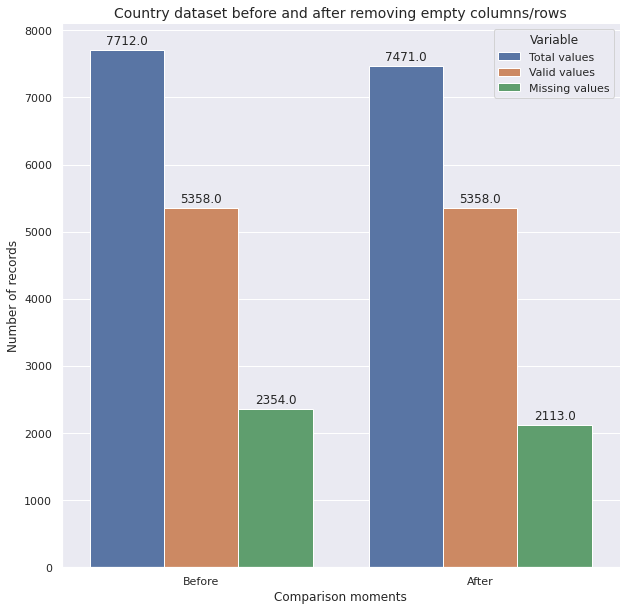

In [25]:
df_comparison = comparison_dfs(country, country_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Country dataset before and after removing empty columns/rows", size=14)
sns.despine(fig)

### Comparing **`"Serie"`** dataset before and after removing empty columns/rows

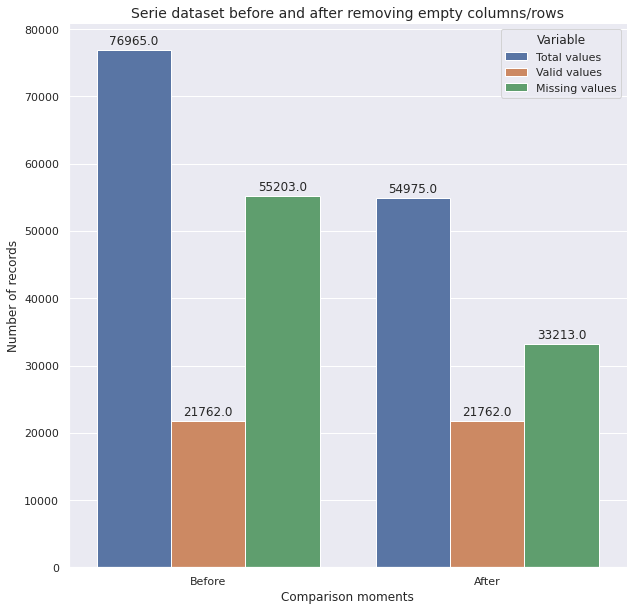

In [26]:
df_comparison = comparison_dfs(serie, serie_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Serie dataset before and after removing empty columns/rows", size=14)
sns.despine(fig)

### Comparing **`"Country-Serie"`** dataset before and after removing empty columns/rows

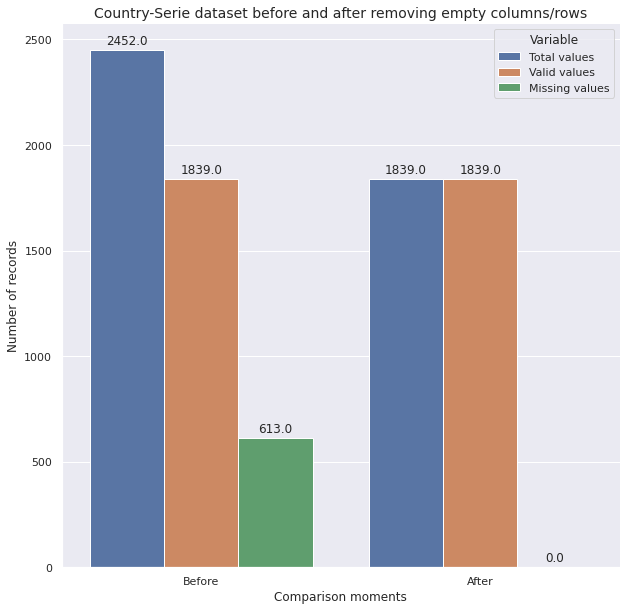

In [27]:
df_comparison = comparison_dfs(country_serie, country_serie_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Country-Serie dataset before and after removing empty columns/rows", size=14)
sns.despine(fig)

### Comparing **`"FootNote"`** dataset before and after removing empty columns/rows

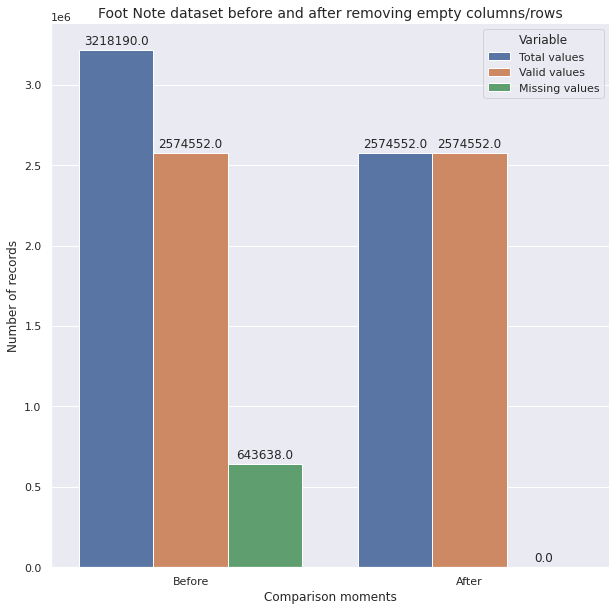

In [28]:
df_comparison = comparison_dfs(foot_note, foot_note_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Foot Note dataset before and after removing empty columns/rows", size=14)
sns.despine(fig)

### Comparing **`"Data"`** dataset before and after removing empty columns/rows

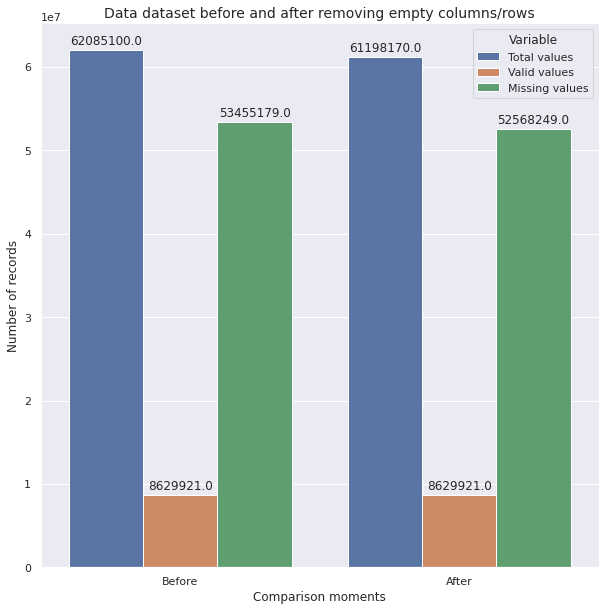

In [29]:
df_comparison = comparison_dfs(data, data_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Data dataset before and after removing empty columns/rows", size=14)
sns.despine(fig)

### Cleaning **`"Country"`** dataset

In [30]:
# List of countries as given in ISO 3166-1 and the corresponding ISO 3166-1-alpha-2 code elements.  
countries_iso = pd.read_csv("datasets/countries_ISO.csv", sep=",", 
                            keep_default_na=False, encoding="utf-8") # Avoiding that "NA" will be interpreted as NaN by Pandas

In [31]:
# Rows to remove based on list of countries as given in ISO 3166-1
df_print = country_copy[~country_copy["2-alpha code"].isin(countries_iso["Code"])]
df_print

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,...,Government Accounting concept,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data
5,ARB,Arab World,Arab World,Arab World,1A,NaN,Arab World aggregate. Arab World is composed o...,NaN,NaN,1A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,CHI,Channel Islands,Channel Islands,Channel Islands,NaN,Pound sterling,NaN,Europe & Central Asia,High income: nonOECD,JG,...,NaN,NaN,Guernsey: 2009; Jersey: 2011.,NaN,NaN,Yes. Vital registration for Guernsey and Jersey.,NaN,NaN,NaN,NaN
57,EAP,East Asia & Pacific (developing only),East Asia & Pacific,East Asia & Pacific (developing only),4E,NaN,East Asia and Pacific regional aggregate (does...,NaN,NaN,4E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,EAS,East Asia & Pacific (all income levels),East Asia & Pacific (all income levels),East Asia & Pacific (all income levels),Z4,NaN,East Asia and Pacific regional aggregate (incl...,NaN,NaN,Z4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,ECA,Europe & Central Asia (developing only),Europe & Central Asia,Europe & Central Asia (developing only),7E,NaN,Europe and Central Asia regional aggregate (do...,NaN,NaN,7E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,ECS,Europe & Central Asia (all income levels),Europe & Central Asia (all income levels),Europe & Central Asia (all income levels),Z7,NaN,Europe and Central Asia regional aggregate (in...,NaN,NaN,Z7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,EMU,Euro area,Euro area,Euro area,XC,NaN,Euro area aggregate.,NaN,NaN,XC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,EUU,European Union,European Union,European Union,EU,NaN,European Union aggregate.,NaN,NaN,EU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,HIC,High income,High income,High income,XD,NaN,High income group aggregate. High-income econo...,NaN,NaN,XD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,HPC,Heavily indebted poor countries (HIPC),Heavily indebted poor countries (HIPC),Heavily indebted poor countries (HIPC),XE,NaN,Heavily indebted poor countries aggregate.,NaN,NaN,XE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Filter "EdStatsCountry.csv" based on the list of countries as given in ISO 3166-1
country_copy = country_copy[country_copy["2-alpha code"].isin(countries_iso["Code"])]

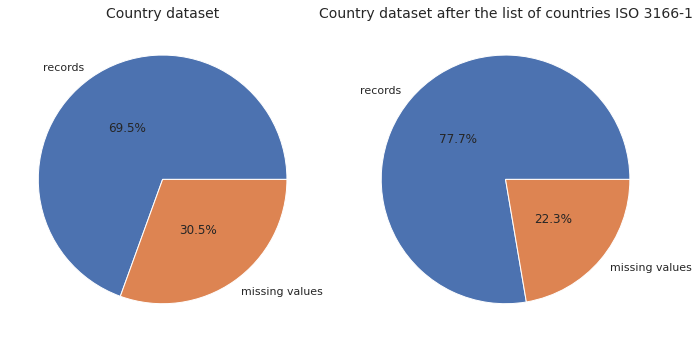

In [33]:
# Comparing missing values in Country dataset before and after removing empty columns/rows
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[10,20])
labels = ["records", "missing values"]
explode = (0, 0.01)

vals_ax1 = [prod(country.shape)-country.isna().sum().sum(), country.isna().sum().sum()]
ax1.pie(x=vals_ax1, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax1.set_title("Country dataset", fontsize=14)

vals_ax2 = [prod(country_copy.shape)-country_copy.isna().sum().sum(), country_copy.isna().sum().sum()]
ax2.pie(x=vals_ax2, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax2.set_title("Country dataset after the list of countries ISO 3166-1", fontsize=14)

plt.tight_layout()
plt.show()

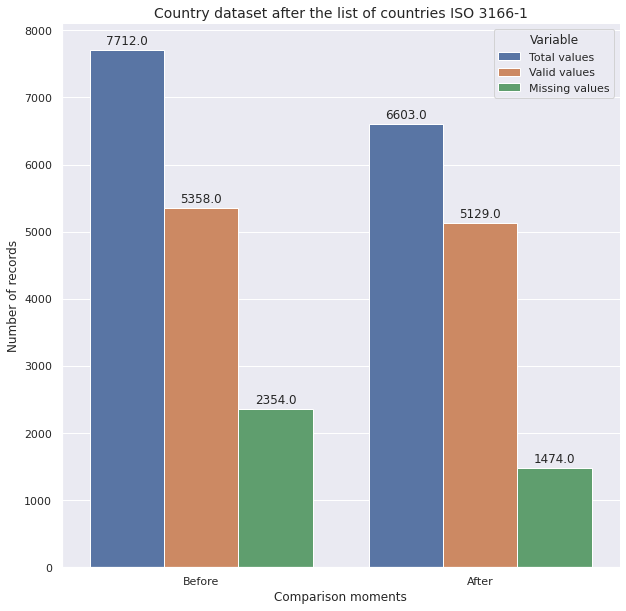

In [34]:
df_comparison = comparison_dfs(country, country_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Country dataset after the list of countries ISO 3166-1", size=14)
sns.despine(fig)

In [35]:
df_initial_analysis(country_copy, "country copy")


Initial Analysis of country copy dataset
--------------------------------------------------------------------------
- Dataset shape:                  213 rows and 31 columns
- Total of NaN values:            1474
- Percentage of NaN:              22.32 %
- Total of full duplicates rows:  0
- Total of empty columns:         0

- Type object and records by columns
--------------------------------------------------------------------------
                                                 Name     Type  Records
0                                        Country Code   object      213
9                                           WB-2 code   object      213
2                                          Table Name   object      213
3                                           Long Name   object      213
4                                        2-alpha code   object      213
1                                          Short Name   object      213
15                        System of National Accounts  

In [36]:
country_copy.head(n=5)

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,...,Government Accounting concept,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data
0,ABW,Aruba,Aruba,Aruba,AW,Aruban florin,SNA data for 2000-2011 are updated from offici...,Latin America & Caribbean,High income: nonOECD,AW,...,NaN,NaN,2010,NaN,NaN,Yes,NaN,NaN,2012.0,NaN
1,AFG,Afghanistan,Afghanistan,Islamic State of Afghanistan,AF,Afghan afghani,Fiscal year end: March 20; reporting period fo...,South Asia,Low income,AF,...,Consolidated central government,General Data Dissemination System (GDDS),1979,"Multiple Indicator Cluster Survey (MICS), 2010/11","Integrated household survey (IHS), 2008",NaN,2013/14,NaN,2012.0,2000
2,AGO,Angola,Angola,People's Republic of Angola,AO,Angolan kwanza,"April 2013 database update: Based on IMF data,...",Sub-Saharan Africa,Upper middle income,AO,...,Budgetary central government,General Data Dissemination System (GDDS),1970,"Malaria Indicator Survey (MIS), 2011","Integrated household survey (IHS), 2008",NaN,2015,NaN,NaN,2005
3,ALB,Albania,Albania,Republic of Albania,AL,Albanian lek,NaN,Europe & Central Asia,Upper middle income,AL,...,Budgetary central government,General Data Dissemination System (GDDS),2011,"Demographic and Health Survey (DHS), 2008/09",Living Standards Measurement Study Survey (LSM...,Yes,2012,2010.0,2012.0,2006
4,AND,Andorra,Andorra,Principality of Andorra,AD,Euro,NaN,Europe & Central Asia,High income: nonOECD,AD,...,NaN,NaN,2011. Population figures compiled from adminis...,NaN,NaN,Yes,NaN,NaN,2006.0,NaN


### Cleaning **`"FootNote"`** dataset

In [37]:
# Rows to remove based on list of countries as given in ISO 3166-1
df_print = foot_note_copy[~foot_note_copy["CountryCode"].isin(country_copy["Country Code"])]
df_print

,CountryCode,SeriesCode,Year,DESCRIPTION
7894,ARB,UIS.REPP.2.GPV.M,YR2006,UNESCO Institute for Statistics (UIS) estimate
7895,ARB,UIS.REPP.2.GPV.M,YR2007,UNESCO Institute for Statistics (UIS) estimate
7896,ARB,UIS.REPP.2.GPV.M,YR2008,UNESCO Institute for Statistics (UIS) estimate
7897,ARB,UIS.REPP.2.GPV.M,YR2011,UNESCO Institute for Statistics (UIS) estimate
7898,ARB,UIS.REPP.2.GPV.M,YR2014,UNESCO Institute for Statistics (UIS) estimate
...,...,...,...,...
635823,XKX,SP.POP.GROW,YR2017,5-year average value between 0s and 5s
635824,XKX,SP.POP.TOTL,YR2001,Interpolated between 2000 and 2005 assuming co...
635825,XKX,SP.POP.TOTL,YR2002,Interpolated between 2000 and 2005 assuming co...
635826,XKX,SP.POP.TOTL,YR2003,Interpolated between 2000 and 2005 assuming co...


In [38]:
# Filter "foot_note_copy" based on the list of "country_copy"
foot_note_copy = foot_note_copy[foot_note_copy["CountryCode"].isin(country_copy["Country Code"])]

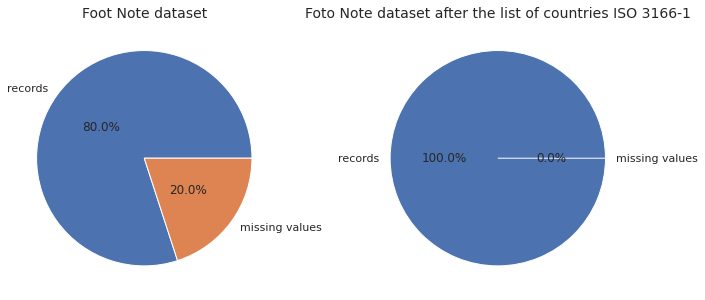

In [39]:
# Comparing missing values in Foot Note dataset before and after removing empty columns/rows
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[10,20])
labels = ["records", "missing values"]
explode = (0, 0.01)

vals_ax1 = [prod(foot_note.shape)-foot_note.isna().sum().sum(), foot_note.isna().sum().sum()]
ax1.pie(x=vals_ax1, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax1.set_title("Foot Note dataset", fontsize=14)

vals_ax2 = [prod(foot_note_copy.shape)-foot_note_copy.isna().sum().sum(), foot_note_copy.isna().sum().sum()]
ax2.pie(x=vals_ax2, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax2.set_title("Foto Note dataset after the list of countries ISO 3166-1", fontsize=14)

plt.tight_layout()
plt.show()

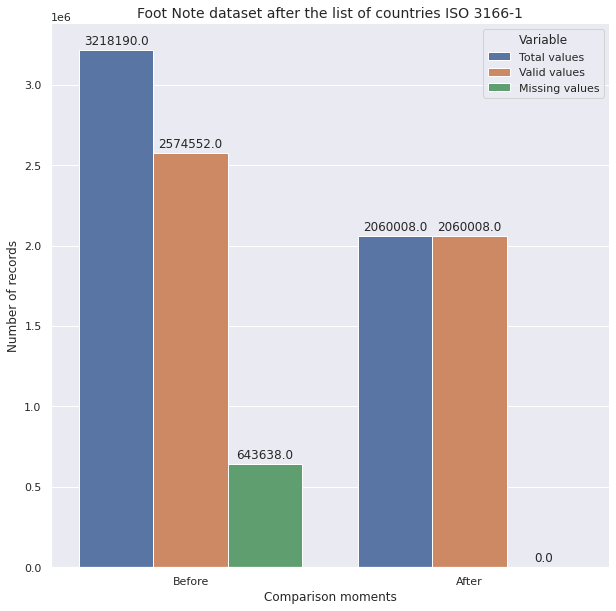

In [40]:
df_comparison = comparison_dfs(foot_note, foot_note_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Foot Note dataset after the list of countries ISO 3166-1", size=14)
sns.despine(fig)

In [41]:
df_initial_analysis(foot_note_copy, "foot note copy")


Initial Analysis of foot note copy dataset
--------------------------------------------------------------------------
- Dataset shape:                  515002 rows and 4 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty columns:         0

- Type object and records by columns
--------------------------------------------------------------------------
          Name    Type  Records
0  CountryCode  object   515002
1   SeriesCode  object   515002
2         Year  object   515002
3  DESCRIPTION  object   515002


In [42]:
foot_note_copy.head(n=5)


,CountryCode,SeriesCode,Year,DESCRIPTION
0,ABW,SE.PRE.ENRL.FE,YR2001,Country estimation.
1,ABW,SE.TER.TCHR.FE,YR2005,Country estimation.
2,ABW,SE.PRE.TCHR.FE,YR2000,Country estimation.
3,ABW,SE.SEC.ENRL.GC,YR2004,Country estimation.
4,ABW,SE.PRE.TCHR,YR2006,Country estimation.


In [43]:
# Formatting columns year to work with it
foot_note_copy["Year"] = foot_note_copy["Year"].str.replace("YR", "")
foot_note_copy["Year"] = foot_note_copy["Year"].str.replace("yr", "")



In [44]:
foot_note_copy.head(n=5)

,CountryCode,SeriesCode,Year,DESCRIPTION
0,ABW,SE.PRE.ENRL.FE,2001,Country estimation.
1,ABW,SE.TER.TCHR.FE,2005,Country estimation.
2,ABW,SE.PRE.TCHR.FE,2000,Country estimation.
3,ABW,SE.SEC.ENRL.GC,2004,Country estimation.
4,ABW,SE.PRE.TCHR,2006,Country estimation.


### Cleaning **`"Country-Series"`** dataset

In [45]:
# Rows to remove based on list of countries as given in ISO 3166-1
df_print = country_serie_copy[~country_serie_copy["CountryCode"].isin(country_copy["Country Code"])]
df_print

,CountryCode,SeriesCode,DESCRIPTION
84,CHI,SP.POP.TOTL,Data sources : United Nations World Population...
85,CHI,SP.POP.0014.TO.ZS,"Refers to Guernsey, and Jersey."
86,CHI,SP.POP.1564.TO.ZS,"Refers to Guernsey, and Jersey."
87,CHI,SP.POP.GROW,Data sources: United Nations World Population ...
88,CHI,SP.POP.TOTL.FE.ZS,"Refers to Guernsey, and Jersey."
89,CHI,SP.POP.TOTL.MA.ZS,"Refers to Guernsey, and Jersey."
392,NAM,SP.POP.GROW,Data sources: United Nations World Population ...
393,NAM,SP.POP.TOTL,Data sources : United Nations World Population...
597,XKX,SP.POP.TOTL,Data sources : World Bank's Kosovo coutnry off...
598,XKX,NY.GDP.MKTP.PP.KD,Estimates are based on regression.


In [46]:
# Filter "country_serie_copy" based on the list of "country_copy"
country_serie_copy = country_serie_copy[country_serie_copy["CountryCode"].isin(country_copy["Country Code"])]

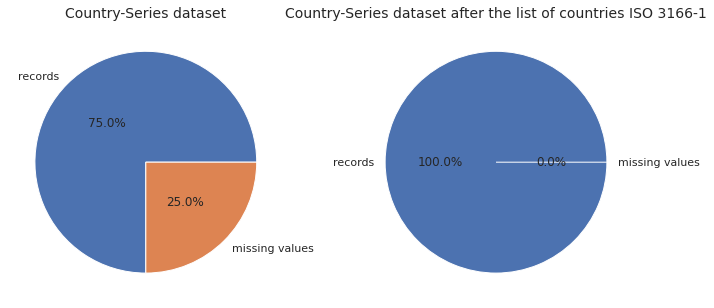

In [47]:
# Comparing missing values in Country-Series dataset before and after removing empty columns/rows
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[10,20])
labels = ["records", "missing values"]
explode = (0, 0.01)

vals_ax1 = [prod(country_serie.shape)-country_serie.isna().sum().sum(), country_serie.isna().sum().sum()]
ax1.pie(x=vals_ax1, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax1.set_title("Country-Series dataset", fontsize=14)

vals_ax2 = [prod(country_serie_copy.shape)-country_serie_copy.isna().sum().sum(), country_serie_copy.isna().sum().sum()]
ax2.pie(x=vals_ax2, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax2.set_title("Country-Series dataset after the list of countries ISO 3166-1", fontsize=14)

plt.tight_layout()
plt.show()

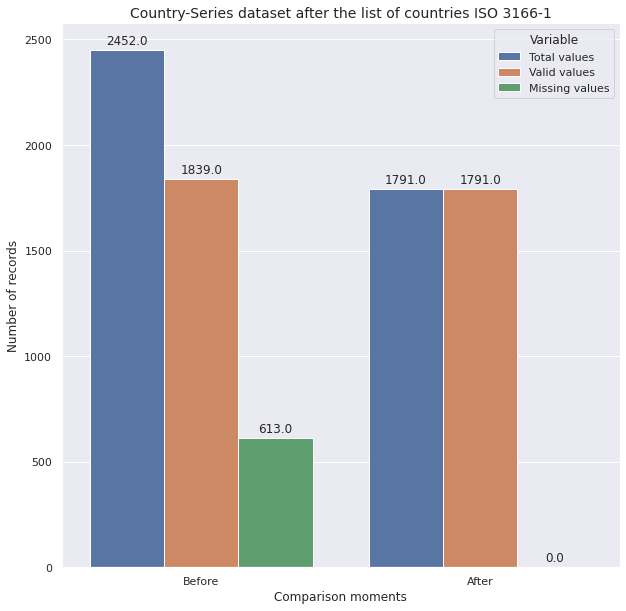

In [48]:
df_comparison = comparison_dfs(country_serie, country_serie_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Country-Series dataset after the list of countries ISO 3166-1", size=14)
sns.despine(fig)

In [49]:
df_initial_analysis(country_serie_copy, "country-series copy")


Initial Analysis of country-series copy dataset
--------------------------------------------------------------------------
- Dataset shape:                  597 rows and 3 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty columns:         0

- Type object and records by columns
--------------------------------------------------------------------------
          Name    Type  Records
0  CountryCode  object      597
1   SeriesCode  object      597
2  DESCRIPTION  object      597


### Cleaning **`"Data"`** dataset

In [50]:
# Rows to remove based on list of countries as given in ISO 3166-1
df_print = data_copy[~data_copy["Country Code"].isin(country_copy["Country Code"])]
df_print

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
0,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR,54.822121,54.894138,56.209438,57.267109,57.991138,59.36554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593725,Namibia,NAM,"Youth illiterate population, 15-24 years, male...",UIS.LP.AG15T24.M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
593726,Namibia,NAM,"Youth literacy rate, population 15-24 years, b...",SE.ADT.1524.LT.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
593727,Namibia,NAM,"Youth literacy rate, population 15-24 years, f...",SE.ADT.1524.LT.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
593728,Namibia,NAM,"Youth literacy rate, population 15-24 years, g...",SE.ADT.1524.LT.FM.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# Filter "country_serie_copy" based on the list of "country_copy"
data_copy = data_copy[data_copy["Country Code"].isin(country_copy["Country Code"])]

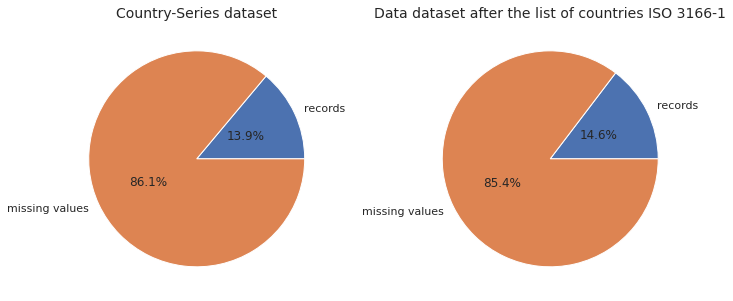

In [52]:
# Comparing missing values in Data dataset before and after removing empty columns/rows
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[10,20])
labels = ["records", "missing values"]
explode = (0, 0.01)

vals_ax1 = [prod(data.shape)-data.isna().sum().sum(), data.isna().sum().sum()]
ax1.pie(x=vals_ax1, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax1.set_title("Country-Series dataset", fontsize=14)

vals_ax2 = [prod(data_copy.shape)-data_copy.isna().sum().sum(), data_copy.isna().sum().sum()]
ax2.pie(x=vals_ax2, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax2.set_title("Data dataset after the list of countries ISO 3166-1", fontsize=14)

plt.tight_layout()
plt.show()

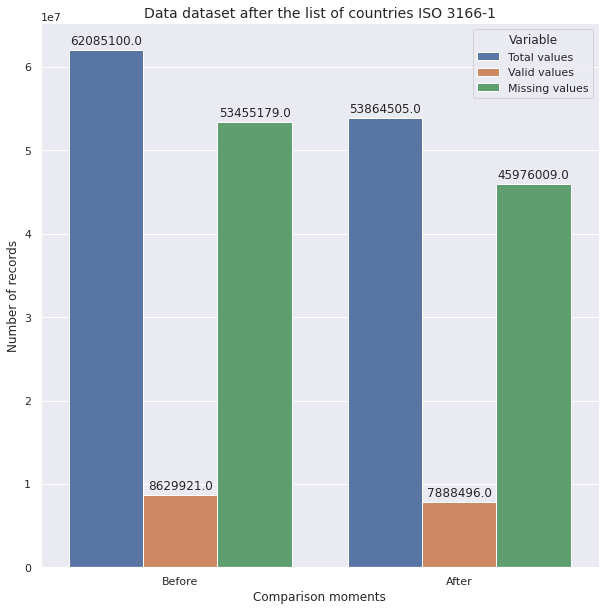

In [53]:
df_comparison = comparison_dfs(data, data_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Data dataset after the list of countries ISO 3166-1", size=14)
sns.despine(fig)

In [54]:
df_initial_analysis(data_copy, "data copy")


Initial Analysis of data copy dataset
--------------------------------------------------------------------------
- Dataset shape:                  780645 rows and 69 columns
- Total of NaN values:            45976009
- Percentage of NaN:              85.35 %
- Total of full duplicates rows:  0
- Total of empty columns:         0

- Type object and records by columns
--------------------------------------------------------------------------
              Name     Type  Records
0     Country Name   object   780645
1     Country Code   object   780645
2   Indicator Name   object   780645
3   Indicator Code   object   780645
44            2010  float64   232268
..             ...      ...      ...
6             1972  float64    31535
8             1974  float64    31495
7             1973  float64    31332
50            2016  float64    15600
51            2017  float64      143

[69 rows x 3 columns]


### Cleaning **`"Series"`** dataset

In [55]:
# Rows to remove based on list of countries as given in ISO 3166-1 and Data dataset as well. 
# In this case base on series filtered by list of countries
df_print = serie_copy[~serie_copy["Series Code"].isin(data_copy["Indicator Code"])]
df_print

,Series Code,Topic,Indicator Name,Short definition,Long definition,Periodicity,Base Period,Other notes,Aggregation method,Limitations and exceptions,General comments,Source,Statistical concept and methodology,Development relevance,Related source links
2292,SE.SEC.DURS.LO,Secondary,Theoretical duration of lower secondary educat...,NaN,Number of grades (years) in lower secondary ed...,NaN,NaN,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN
2314,SE.SEC.ENRR.UP.FE,Secondary,"Gross enrolment ratio, upper secondary, female...",NaN,Total female enrollment in upper secondary edu...,NaN,NaN,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN
2717,UIS.AIR.1.Glast.GPI,Primary,"Primary completion rate, gender parity index (...",NaN,Ratio of the female primary completion rate to...,NaN,NaN,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN
2724,UIS.CEAge.1,Background,Official entrance age to compulsory education ...,NaN,Official age when students should enter compul...,NaN,NaN,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN
2764,UIS.E.0.Pu.F,Early Childhood Education,"Enrolment in early childhood education, public...",NaN,Total number of females enrolled in public ear...,NaN,NaN,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN
2791,UIS.E.1.Guk,Primary,"Enrolment in primary education, Grade unspecif...",NaN,Total number of students enrolled in unspecifi...,NaN,NaN,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN
2792,UIS.E.1.Guk.F,Primary,"Enrolment in primary education, Grade unspecif...",NaN,Total number of female students enrolled in un...,NaN,NaN,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN
2795,UIS.E.1.Pu,Primary,"Enrolment in primary education, public institu...",NaN,Total number of individuals enrolled in public...,NaN,NaN,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN
2796,UIS.E.1.Pu.F,Primary,"Enrolment in primary education, public institu...",NaN,Total number of females enrolled in public pri...,NaN,NaN,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN
2818,UIS.E.2.Pu.F,Secondary,"Enrolment in lower secondary education, public...",NaN,Total number of females enrolled in public low...,NaN,NaN,NaN,NaN,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN


In [56]:
# Filter "serie_copy" based on the list of "country_copy"
# In this case base on series filtered by list of countries
serie_copy = serie_copy[serie_copy["Series Code"].isin(data_copy["Indicator Code"])]

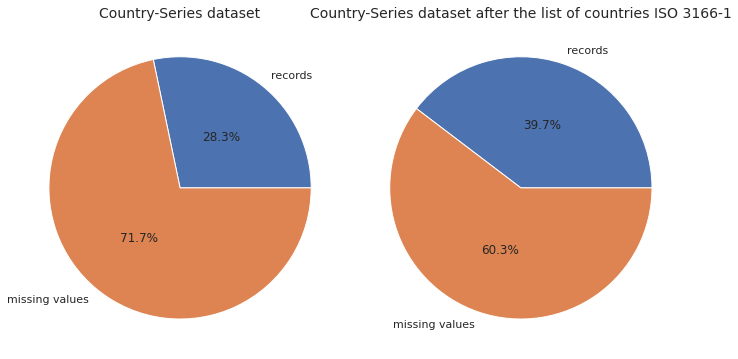

In [57]:
# Comparing missing values in Series dataset before and after removing empty columns/rows
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[10,20])
labels = ["records", "missing values"]
explode = (0, 0.01)

vals_ax1 = [prod(serie.shape)-serie.isna().sum().sum(), serie.isna().sum().sum()]
ax1.pie(x=vals_ax1, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax1.set_title("Country-Series dataset", fontsize=14)

vals_ax2 = [prod(serie_copy.shape)-serie_copy.isna().sum().sum(), serie_copy.isna().sum().sum()]
ax2.pie(x=vals_ax2, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax2.set_title("Country-Series dataset after the list of countries ISO 3166-1", fontsize=14)

plt.tight_layout()
plt.show()


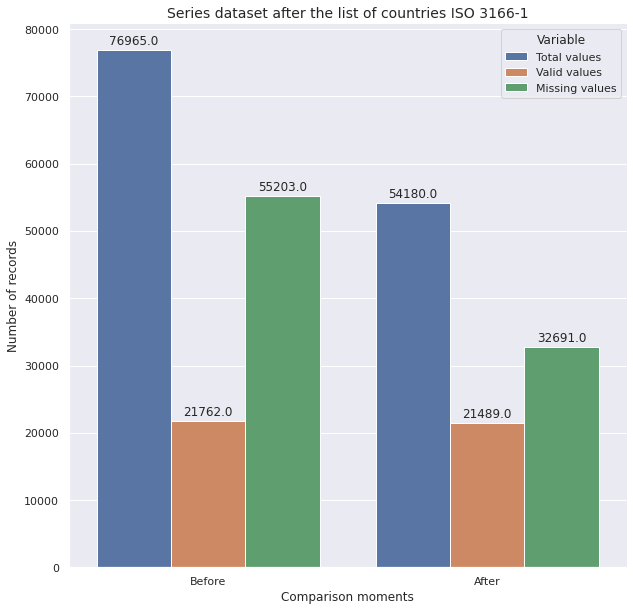

In [58]:
df_comparison = comparison_dfs(serie, serie_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Series dataset after the list of countries ISO 3166-1", size=14)
sns.despine(fig)

In [59]:
df_initial_analysis(serie_copy, "series copy")


Initial Analysis of series copy dataset
--------------------------------------------------------------------------
- Dataset shape:                  3612 rows and 15 columns
- Total of NaN values:            32691
- Percentage of NaN:              60.34 %
- Total of full duplicates rows:  0
- Total of empty columns:         0

- Type object and records by columns
--------------------------------------------------------------------------
                                   Name    Type  Records
0                           Series Code  object     3612
1                                 Topic  object     3612
2                        Indicator Name  object     3612
4                       Long definition  object     3612
11                               Source  object     3612
3                      Short definition  object     2152
7                           Other notes  object      548
6                           Base Period  object      314
14                 Related source links  obje

## Analysis of data
- Data number by year.
    - **`"Foot Note"`** dataset **`"EdStatsFootNote.csv"`**.<br>
    L’année d’origine des données et aussi une description sur les indicateurs.
    - Amount of countries by year.
- Amount of data by:
    - Country
    - Region
- Incomes types by Region
- Analyzing the indicators

### Analysis of data

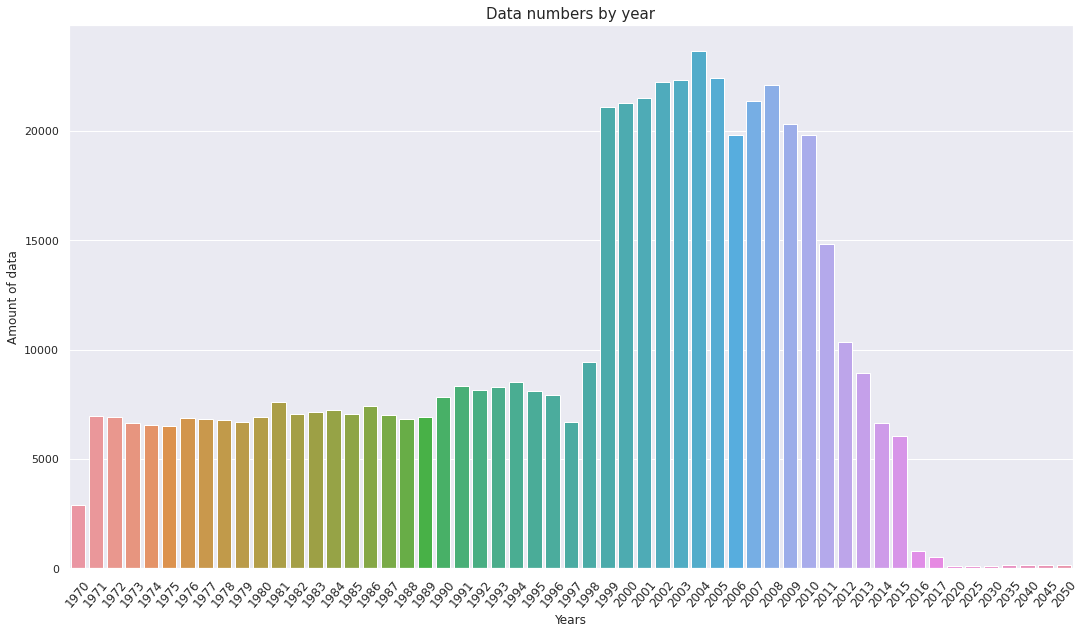

In [60]:
# Graph amount of data by year
plt.figure(figsize=(18, 10))
plt.title("Data numbers by year", size=15)
plot = sns.barplot(y="SeriesCode", x="Year", data=foot_note_copy.groupby("Year").count().reset_index())
plot.set_xticklabels(labels=foot_note_copy.groupby("Year").count().reset_index()["Year"], rotation=50, size=12)
plot.set(xlabel="Years", ylabel="Amount of data")
plt.show()

In [61]:
data_copy.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978',
       '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987',
       '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',
       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2020', '2025', '2030', '2035', '2040', '2045',
       '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090',
       '2095', '2100'],
      dtype='object')

In [62]:
# Years present within Data dataset
YEARS = [
    "1970", "1971", "1972", "1973", "1974", "1975", "1976", "1977", "1978", "1979", "1980", "1981", 
    "1982", "1983", "1984", "1985", "1986", "1987", "1988", "1989", "1990", "1991", "1992", "1993",
    "1994", "1995", "1996", "1997", "1998", "1999", "2000", "2001", "2002", "2003", "2004", "2005",
    "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017",
    "2020", "2025", "2030", "2035", "2040", "2045", "2050"
]

In [63]:
# Analyzing amount of countries by year
list_countries_by_year = YEARS
list_countries_by_year.append("Country Code")

In [64]:
print(", ".join(map(repr, list_countries_by_year)))

'1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2020', '2025', '2030', '2035', '2040', '2045', '2050', 'Country Code'


In [65]:

df_countries_by_year = pd.DataFrame(data_copy[list_countries_by_year]).dropna(axis="rows", how="all").dropna(axis="columns", how="all")
df_countries_by_year

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2016,2017,2020,2025,2030,2035,2040,2045,2050,Country Code
91625,NaN,NaN,NaN,NaN,7.05911,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AFG
91626,NaN,NaN,NaN,NaN,2.53138,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AFG
91627,NaN,NaN,NaN,NaN,0.22154,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AFG
91628,NaN,NaN,NaN,NaN,11.42652,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AFG
91629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AFG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ZWE
886926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ZWE
886927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ZWE
886928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ZWE


In [66]:
# Calculating the amount of countries by year. 
df_countries_by_year = countries_by_year(df_countries_by_year)
df_countries_by_year.head(10)

,Year,Countries
0,1970,212
1,1971,212
2,1972,212
3,1973,212
4,1974,212
5,1975,212
6,1976,212
7,1977,212
8,1978,212
9,1979,212


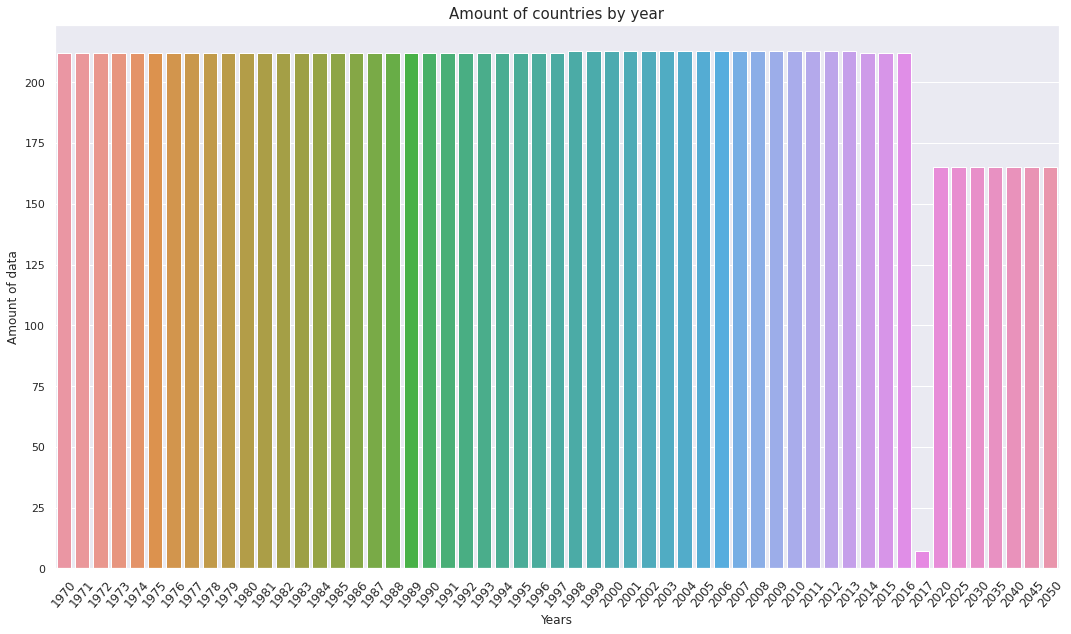

In [67]:
# Graph amount of countries by year
plt.figure(figsize=(18, 10))
plt.title("Amount of countries by year", size=15)
plot = sns.barplot(y="Countries", x="Year", data=df_countries_by_year)
plot.set_xticklabels(labels=df_countries_by_year["Year"], rotation=50, size=12)
plot.set(xlabel="Years", ylabel="Amount of data")
plt.show()

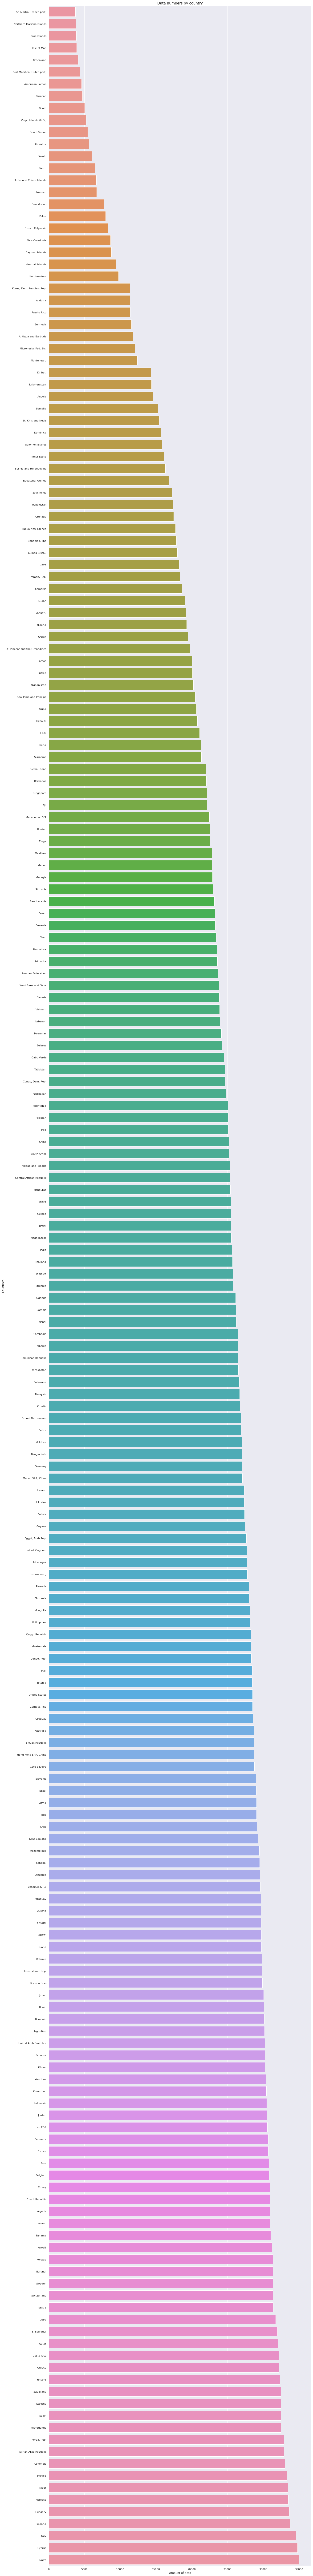

In [68]:
# Graph amount of data by country
plt.figure(figsize=(20, 200))
plt.title("Data numbers by country", size=15)
plot = sns.barplot(x=data_copy.groupby("Country Name")[YEARS].count().sum(axis=1).sort_values().values,
                   y=data_copy.groupby("Country Name")[YEARS].count().sum(axis=1).sort_values().index
)
plot.set(xlabel="Amount of data", ylabel="Countries")
plt.show()

In [69]:
# Adding column region within Data dataset
data_copy = data_copy.merge(right = country_copy[['Country Code', 'Region']], 
                  on='Country Code', how='left')

In [70]:
data_copy.head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2060,2065,2070,2075,2080,2085,2090,2095,2100,Region
0,Afghanistan,AFG,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2,NaN,NaN,NaN,NaN,7.05911,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Asia
1,Afghanistan,AFG,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F,NaN,NaN,NaN,NaN,2.53138,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Asia
2,Afghanistan,AFG,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,0.22154,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Asia
3,Afghanistan,AFG,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.M,NaN,NaN,NaN,NaN,11.42652,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Asia
4,Afghanistan,AFG,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Asia


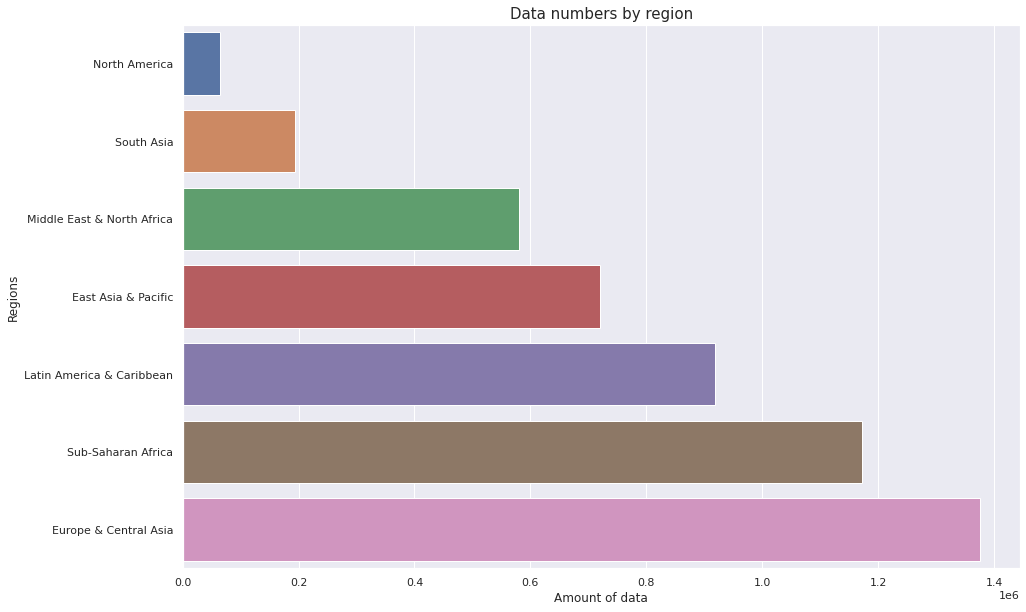

In [71]:
# Graph amount of data by region
plt.figure(figsize=(15, 10))
plt.title("Data numbers by region", size=15)
plot = sns.barplot(x=data_copy.groupby("Region")[YEARS].count().sum(axis=1).sort_values().values,
                   y=data_copy.groupby("Region")[YEARS].count().sum(axis=1).sort_values().index
)
plot.set(xlabel="Amount of data", ylabel="Regions")
plt.show()

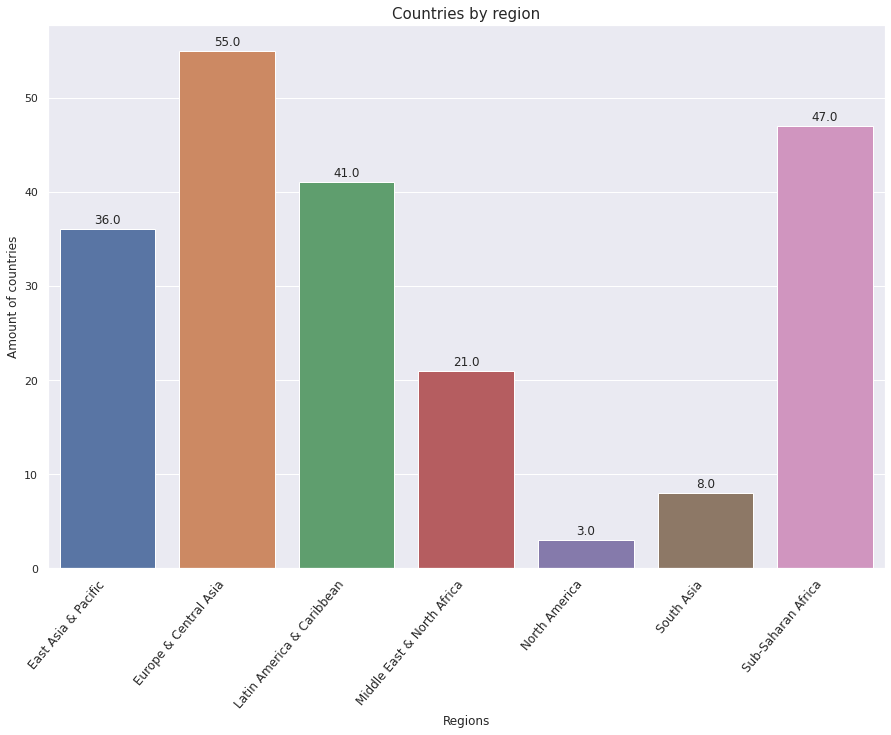

In [72]:
# Graph countries by region
df_countries_by_region = country_copy[["Short Name", "Region"]].groupby("Region").count()

plt.figure(figsize=(15, 10))
plt.title("Countries by region", size=15)
plot = sns.barplot(x="Region", y="Short Name", data=df_countries_by_region.reset_index())
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Regions", size=12)
plt.ylabel("Amount of countries", size=12)
plot.set_xticklabels(labels=plot.get_xticklabels(), rotation=50, size=12, horizontalalignment="right")
plt.show()

In [73]:
# Filtering and grouping by Income Group and Region
df_types_incomes_by_region = pd.DataFrame(country_copy[["Income Group", "Short Name", "Region"]]
                                            .groupby(["Income Group", "Region"])["Short Name"].count()).reset_index()

In [74]:
df_types_incomes_by_region.head(8)

,Income Group,Region,Short Name
0,High income: OECD,East Asia & Pacific,4
1,High income: OECD,Europe & Central Asia,23
2,High income: OECD,Latin America & Caribbean,1
3,High income: OECD,Middle East & North Africa,1
4,High income: OECD,North America,2
5,High income: nonOECD,East Asia & Pacific,8
6,High income: nonOECD,Europe & Central Asia,12
7,High income: nonOECD,Latin America & Caribbean,14


In [75]:
# Knowing the Incomes types
list(df_types_incomes_by_region["Income Group"].unique())

['High income: OECD',
 'High income: nonOECD',
 'Low income',
 'Lower middle income',
 'Upper middle income']

In [76]:
# Creating DataFrame order to add it within df_types_incomes_by_region
df_incomes_order = pd.DataFrame({
    "Income Group" : ["High income: OECD", "High income: nonOECD", "Upper middle income", "Lower middle income", "Low income"], 
    "Order" : [0, 1, 2, 3, 4]
})
df_incomes_order

,Income Group,Order
0,High income: OECD,0
1,High income: nonOECD,1
2,Upper middle income,2
3,Lower middle income,3
4,Low income,4


In [77]:
# Adding order column to improve the graph
df_types_incomes_by_region = pd.merge(df_types_incomes_by_region, df_incomes_order).sort_values("Order")
df_types_incomes_by_region.head(12)

,Income Group,Region,Short Name,Order
0,High income: OECD,East Asia & Pacific,4,0
1,High income: OECD,Europe & Central Asia,23,0
2,High income: OECD,Latin America & Caribbean,1,0
3,High income: OECD,Middle East & North Africa,1,0
4,High income: OECD,North America,2,0
5,High income: nonOECD,East Asia & Pacific,8,1
6,High income: nonOECD,Europe & Central Asia,12,1
7,High income: nonOECD,Latin America & Caribbean,14,1
8,High income: nonOECD,Middle East & North Africa,7,1
9,High income: nonOECD,North America,1,1


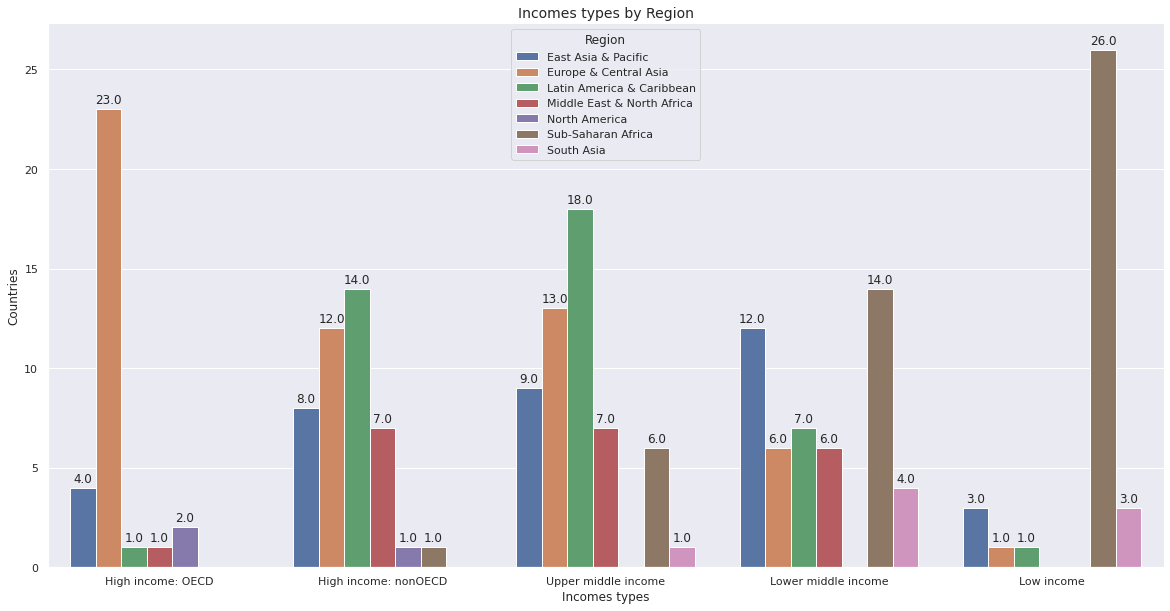

In [78]:
fig, ax1 = plt.subplots(figsize=(20, 10))
plot = sns.barplot(x="Income Group", y="Short Name", hue="Region", data=df_types_incomes_by_region, ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Incomes types", size=12)
plt.ylabel("Countries", size=12)
plt.title("Incomes types by Region", size=14)
sns.despine(fig)

In [79]:
# Amount of Indicators in Data dataset
data_copy['Indicator Code'].nunique()

3665

In [106]:
# Amount of Indicators by country
df_indicators_by_country = pd.DataFrame(data_copy[["Country Name", "Indicator Code"]]\
                                        .groupby("Country Name")["Indicator Code"].count()).reset_index()

In [107]:
df_indicators_by_country

,Country Name,Indicator Code
0,Afghanistan,3665
1,Albania,3665
2,Algeria,3665
3,American Samoa,3665
4,Andorra,3665
...,...,...
208,Virgin Islands (U.S.),3665
209,West Bank and Gaza,3665
210,"Yemen, Rep.",3665
211,Zambia,3665


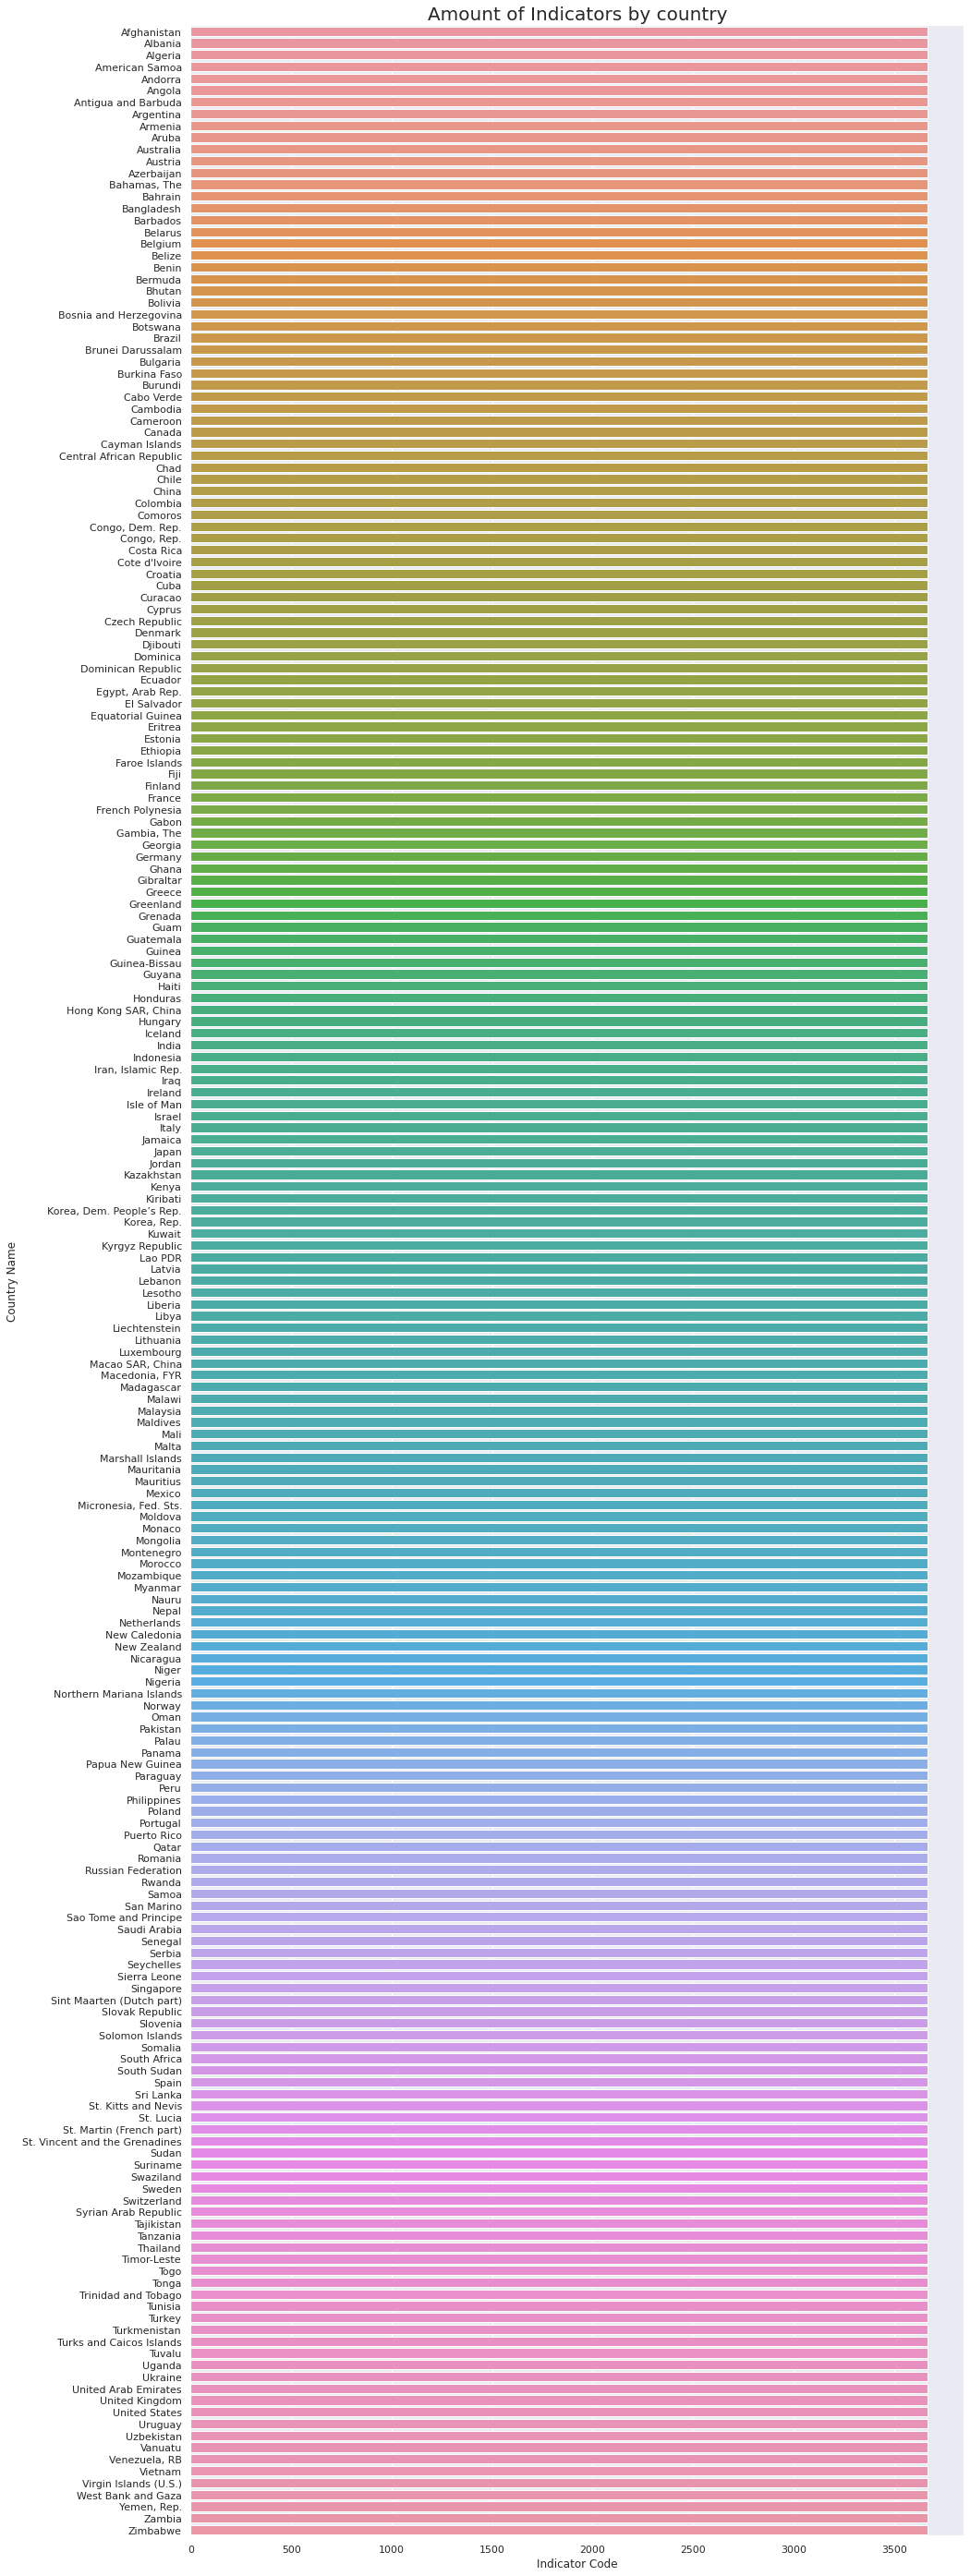

In [114]:
# Amount of Indicators by country
plt.figure(figsize=(15, 50))
sns.barplot(y="Country Name", x="Indicator Code", data=df_indicators_by_country)
plt.title("Amount of Indicators by country", size=20)
plot.set(xlabel="Amount", ylabel="Countries")
plt.show()

In [80]:
# Identify the most common words
df_most_common_words = most_common_words(data_copy["Indicator Name"].tolist(), 20)
print(df_most_common_words)

            Word  Occurence number
19    Repetition              8946
18    Government              9159
17       SACMEQ:             11502
16         Gross             12993
15        PIAAC:             20874
14         PISA:             21087
13        TIMSS:             21300
12        Africa             21513
11     Enrolment             21939
10         MICS:             25560
9         LLECE:             27051
8           DHS:             27690
7         PASEC:             29820
6    Population,             41109
5         SABER:             45795
4     Percentage             50907
3           UIS:             51333
2   Wittgenstein             65604
1     Barro-Lee:             76680
0          EGRA:             85839


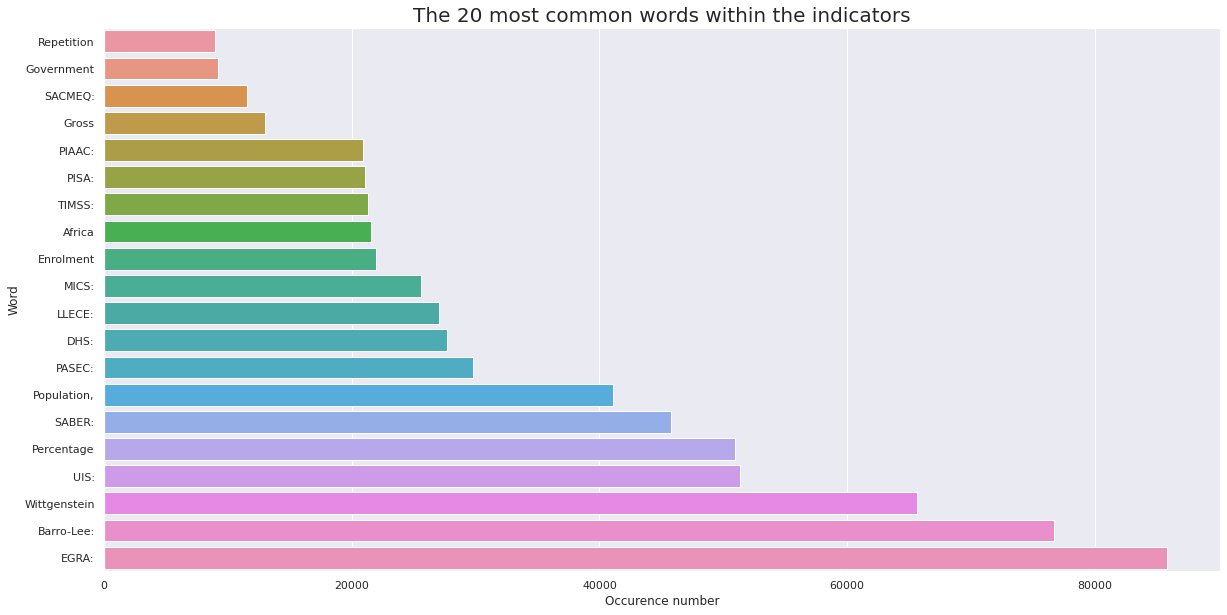

In [81]:
# The most common words within indicator
plt.figure(figsize=(20, 10))
sns.barplot(y="Word", x="Occurence number", data=df_most_common_words)
plt.title("The 20 most common words within the indicators", size=20)
plot.set(xlabel="Occurence number", ylabel="Words")
plt.show()